#**Практическое задание №1**

Установка необходимых пакетов:

In [2]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [4]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [5]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import os

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [6]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Ready, dataset train_tiny contains 900 images.

Got numpy array of shape (224, 224, 3), and label with code 3.
Label code corresponds to LYM class.


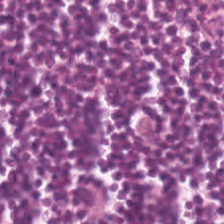

In [22]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [7]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [8]:
class Model:
    def __init__(self, num_classes=9):
        input_shape = (224, 224, 3)
        base_model = tf.keras.applications.MobileNetV2(
            input_shape=input_shape,
            include_top=False,
            weights='imagenet'
        )
        base_model.trainable = False

        self.model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'] #lbl 5
        )

        print("MobileNetV2 model is ready")

    def save(self, name: str):
        model_save_path = f'/content/drive/MyDrive/{name}.keras'
        self.model.save(model_save_path)
        print(f"Model saved in {model_save_path}")

    def load(self, name: str):
        model_load_path = f'/content/drive/MyDrive/{name}.keras'
        if not os.path.exists(model_load_path):
           gdown.download(url="https://drive.google.com/uc?id=1-3w4MVRVgJEGeQftEB-z-G5W3I01Fe61", output=model_load_path, quiet=False)
        self.model = tf.keras.models.load_model(model_load_path)
        print(f"Model downloaded {model_load_path}.")

    def train(self, dataset: Dataset):
        print(f'Learning begins')
        images = dataset.images
        labels = dataset.labels

        unique_labels, counts = np.unique(labels, return_counts=True)
        print("Distribution the training data set:")
        for label, count in zip(unique_labels, counts):
            print(f"Class {label}: {count} images")

        class_weights_array = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=unique_labels,
            y=labels
        )
        class_weights = dict(enumerate(class_weights_array))

        train_images, val_images, train_labels, val_labels = train_test_split(
            images, labels, test_size=0.2, stratify=labels, random_state=42
        )

        train_ds = self.prepare_dataset(train_images, train_labels, batch_size=8, augment=True)
        val_ds = self.prepare_dataset(val_images, val_labels, batch_size=8)


        self.model.fit(
            train_ds,
            validation_data=val_ds, #lbl 1
            epochs=20,
            class_weight=class_weights
        )

        print(f'ТРЕНИРОВКА ОКОНЧЕНА')

    def prepare_dataset(self, images, labels, batch_size, augment=False, shuffle=False):
        dataset = tf.data.Dataset.from_tensor_slices((images, labels))

        def preprocess(img, label):
            img = tf.image.convert_image_dtype(img, tf.float32)
            img = tf.image.resize(img, [224, 224])
            if augment:
                img = self.augment_image(img) # lbl 11
            return img, label

        dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset


    def augment_image(self, img):
      #lbl 11
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        return img

    def test_on_dataset(self, dataset: Dataset, limit=None):
        images = dataset.images
        labels = dataset.labels

        if limit:
            n_samples = int(len(images) * limit)
            images = images[:n_samples]
            labels = labels[:n_samples]

        test_ds = self.prepare_dataset(images, labels, batch_size=32)

        predictions = self.model.predict(test_ds)
        predicted_classes = np.argmax(predictions, axis=1)

        print(classification_report(labels, predicted_classes, target_names=TISSUE_CLASSES))

        return predicted_classes

    def test_on_image(self, img: np.ndarray):
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, [224, 224])
        img = tf.expand_dims(img, axis=0)

        predictions = self.model.predict(img)
        predicted_class = np.argmax(predictions, axis=1)[0]
        return predicted_class

---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [9]:
d_train = Dataset('train')
d_test = Dataset('test_tiny')

Ready, dataset train contains 18000 images.
Ready, dataset test_tiny contains 90 images.


In [10]:
model = Model()
if not EVALUATE_ONLY:
    model.train(d_train)
    model.save('best')
else:
    #todo: your link goes here
    model.load('best')

MobileNetV2 model is ready
Learning begins
Distribution the training data set:
Class 0: 2000 images
Class 1: 2000 images
Class 2: 2000 images
Class 3: 2000 images
Class 4: 2000 images
Class 5: 2000 images
Class 6: 2000 images
Class 7: 2000 images
Class 8: 2000 images
Epoch 1/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - accuracy: 0.6370 - loss: 1.1040 - val_accuracy: 0.8644 - val_loss: 0.4341
Epoch 2/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.8733 - loss: 0.4074 - val_accuracy: 0.8939 - val_loss: 0.3339
Epoch 3/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.8985 - loss: 0.3189 - val_accuracy: 0.9064 - val_loss: 0.2888
Epoch 4/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9089 - loss: 0.2808 - val_accuracy: 0.9119 - val_loss: 0.2632
Epoch 5/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9200 - loss: 0.2540 - val_accuracy: 0.9194 - val_loss: 0.2456
Epoch 6/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.92

Пример тестирования модели на полном наборе данных:

In [11]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step
              precision    recall  f1-score   support

         ADI       1.00      0.90      0.95        10
        BACK       1.00      0.90      0.95        10
         DEB       0.91      1.00      0.95        10
         LYM       1.00      0.90      0.95        10
         MUC       1.00      1.00      1.00        10
         MUS       0.91      1.00      0.95        10
        NORM       1.00      1.00      1.00        10
         STR       0.91      1.00      0.95        10
         TUM       0.90      0.90      0.90        10

    accuracy                           0.96        90
   macro avg       0.96      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90

metrics for test:
	 accuracy 0.9556:
	 balanced accuracy 0.9556:


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [12]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

MobileNetV2 model is ready
Model downloaded /content/drive/MyDrive/best.keras.
Ready, dataset test contains 4500 images.
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step
              precision    recall  f1-score   support

         ADI       1.00      0.98      0.99       500
        BACK       0.99      0.99      0.99       500
         DEB       0.93      0.94      0.93       500
         LYM       0.99      0.97      0.98       500
         MUC       0.94      0.93      0.93       500
         MUS       0.88      0.92      0.90       500
        NORM       0.95      0.91      0.93       500
         STR       0.87      0.89      0.88       500
         TUM       0.93      0.92      0.92       500

    accuracy                           0.94      4500
   macro avg       0.94      0.94      0.94      4500
weighted avg       0.94      0.94      0.94      4500

metrics for test-tiny:
	 accuracy 0.9402:
	 balanced accuracy 0.9402:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()